In [ ]:
import zipfile
import os
import pandas as pd
import numpy as np
import lightgbm
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import pickle
import random


def load_and_downcast_data():
    sales = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/sales_train_evaluation.csv')
    calendar = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/calendar.csv')
    prices = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/sell_prices.csv')


    sales = downcast(sales)
    prices = downcast(prices)
    calendar = downcast(calendar)

    return sales, calendar, prices


def downcast(df):
    for col in df.columns:
        dtype = df[col].dtype

        # Integer types
        if np.issubdtype(dtype, np.integer):
            min_val, max_val = np.iinfo(dtype).min, np.iinfo(dtype).max
            target_type = np.int8 if min_val > np.iinfo(np.int8).min and max_val < np.iinfo(np.int8).max else \
                          np.int16 if min_val > np.iinfo(np.int16).min and max_val < np.iinfo(np.int16).max else \
                          np.int32 if min_val > np.iinfo(np.int32).min and max_val < np.iinfo(np.int32).max else \
                          np.int64

        # Float types
        elif np.issubdtype(dtype, np.floating):
            min_val, max_val = np.finfo(dtype).min, np.finfo(dtype).max
            target_type = np.float16 if min_val > np.finfo(np.float16).min and max_val < np.finfo(np.float16).max else \
                          np.float32 if min_val > np.finfo(np.float32).min and max_val < np.finfo(np.float32).max else \
                          np.float64

        # Object type (handling 'date' separately)
        elif dtype == object:
            target_type = 'category' if col != 'date' else dtype

        # Apply the target data type
        df[col] = df[col].astype(target_type)

    # Memory optimization by downcasting the entire DataFrame
    df = pd.concat([df[col].astype('category') if df[col].dtype.name == 'category' else df[col] for col in df.columns], axis=1)

    random.seed(42)  # Set a seed for reproducibility
    df = df.sample(frac=0.1, random_state=42).reset_index(drop=True)

    return df


    # Implementation of downcast function

def improve_price(prices):
    # Calculate Average price for all stores
    df_mean_store = pd.DataFrame(prices.groupby(['item_id', 'wm_yr_wk'])['sell_price'].mean())
    df_mean_store.columns = ['item_sells_price_avg']
    df_mean_store.reset_index(inplace = True)

    # Combine with calendar
    prices_new = pd.merge(prices, df_mean_store, on=['item_id', 'wm_yr_wk'], how='left', suffixes=('', '_y'))
    prices_new.drop(prices_new.filter(regex='_y$').columns.tolist(),axis=1, inplace=True)

    # Price difference with same items in other stores
    prices_new['delta_price_all_rel'] = (prices_new['sell_price'] -
                                         prices_new['item_sells_price_avg'])/prices_new['item_sells_price_avg']


    # Price difference with last week
    prices_new['item_store'] = prices_new['item_id'].astype(str) + '_' + prices_new['store_id'].astype(str)
    prices_new['item_store_change'] = prices_new["item_store"].shift() != prices_new["item_store"]

    prices_new['delta_price_weekn-1'] = (prices_new['sell_price']-
                                         prices_new['sell_price'].shift(1)).fillna(0)/prices_new['sell_price'].shift(1)
    prices_new['delta_price_weekn-1'] = prices_new['delta_price_weekn-1'].fillna(0) * (prices_new['item_store_change']==0)

    prices_new['dept_id'] = prices_new.item_id.str[:-4]
    df_mean_cat = pd.DataFrame(prices_new.groupby(['dept_id', 'store_id', 'wm_yr_wk'])['sell_price'].mean())
    df_mean_cat.columns = ['dept_sells_price_avg']
    df_mean_cat.reset_index(inplace = True)

    prices_new = pd.merge(prices_new, df_mean_cat, on=['dept_id', 'store_id', 'wm_yr_wk']
                          , how='left', suffixes=('', '_y'))
    prices_new.drop(prices_new.filter(regex='_y$').columns.tolist(),axis=1, inplace=True)

    prices_new['delta_price_cat_rel'] = (prices_new['sell_price'] -
                                         prices_new['dept_sells_price_avg'])/prices_new['dept_sells_price_avg']


    prices_new.drop(['item_sells_price_avg', 'item_store_change', 'item_store_change', 'dept_id', 'item_store',
                    'dept_sells_price_avg'], axis = 1, inplace = True)
    return prices_new


def melt_and_combine(sales, calendar, prices):
    df = pd.melt(sales, id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'],
                 var_name='d', value_name='sold').dropna()

    # Convert categorical columns to 'category' data type
    df['d'] = df['d'].astype('category')
    df['item_id'] = df['item_id'].astype('category')
    df['dept_id'] = df['dept_id'].astype('category')
    df['cat_id'] = df['cat_id'].astype('category')
    df['store_id'] = df['store_id'].astype('category')
    df['state_id'] = df['state_id'].astype('category')

    # Merge operations in a chain
    df = df.merge(calendar, on='d', how='left').merge(prices, on=['store_id', 'item_id', 'wm_yr_wk'], how='left')

    # Drop columns in place
    df.drop(columns=['date'], inplace=True)
    del sales

    return df


def map_category_codes(df):
    df.d = df['d'].apply(lambda x: x.split('_')[1]).astype(np.int16)

    for col in df.dtypes.index.tolist():
        if df[col].dtype.name == 'category':
            df[col] = df[col].cat.codes

    #df.drop('date', axis=1, inplace=True)

    return df

def introduce_lags(df, lags):
    group_cols = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']

    for lag in lags:
        lagged_col = 'sold_lag_' + str(lag)
        df[lagged_col] = df.groupby(group_cols)['sold'].shift(lag).astype(np.float16)

    return df

def calculate_averages(df):
    df['iteam_sold_avg'] = df.groupby('item_id')['sold'].transform('mean').astype(np.float16)
    df['state_sold_avg'] = df.groupby('state_id')['sold'].transform('mean').astype(np.float16)
    df['store_sold_avg'] = df.groupby('store_id')['sold'].transform('mean').astype(np.float16)
    df['cat_sold_avg'] = df.groupby('cat_id')['sold'].transform('mean').astype(np.float16)
    df['dept_sold_avg'] = df.groupby('dept_id')['sold'].transform('mean').astype(np.float16)

    df['cat_dept_sold_avg'] = df.groupby(['cat_id','dept_id'])['sold'].transform('mean').astype(np.float16)
    df['store_item_sold_avg'] = df.groupby(['store_id','item_id'])['sold'].transform('mean').astype(np.float16)
    df['cat_item_sold_avg'] = df.groupby(['cat_id','item_id'])['sold'].transform('mean').astype(np.float16)
    df['dept_item_sold_avg'] = df.groupby(['dept_id','item_id'])['sold'].transform('mean').astype(np.float16)
    df['state_store_sold_avg'] = df.groupby(['state_id','store_id'])['sold'].transform('mean').astype(np.float16)
    df['state_store_cat_sold_avg'] = df.groupby(['state_id','store_id','cat_id'])['sold'].transform('mean').astype(np.float16)
    df['store_cat_dept_sold_avg'] = df.groupby(['store_id','cat_id','dept_id'])['sold'].transform('mean').astype(np.float16)

    return df

# def introduce_rolling_means(df, windows):
#     group_cols = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']

#     for window in windows:
#         col_name = 'rolling_sold_mean_{}'.format(window)
#         df[col_name] = df.groupby(group_cols)['sold'].transform(lambda x: x.rolling(window=window).mean()).astype(np.float16)

#     return df

# def introduce_rolling_lags(df, window_lags):
#     for window, lag in window_lags:
#         df['rolling_lag_{}win{}'.format(window, lag)] = df.groupby(
#         ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']).transform(
#         lambda x: x.rolling(window=window).mean()).astype(np.float16)

#     return df

def calculate_daily_and_total_averages(df):
    df['item_daily_avg_sold'] = df.groupby(
        ['id', 'item_id', 'dept_id', 'cat_id', 'd'])['sold'].transform('mean').astype(np.float16)

    df['item_avg_sold'] = df.groupby(
        ['id', 'item_id', 'dept_id', 'cat_id'])['sold'].transform('mean').astype(np.float16)

    df['item_selling_trend'] = (df['item_daily_avg_sold'] - df['item_avg_sold']).astype(np.float16)

    df.drop(['item_daily_avg_sold','item_avg_sold'], axis=1, inplace=True)

    return df

def introduce_rolling_max(df):
    df['rolling_sold_max'] = df.groupby(
        ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])['sold'].transform(lambda x: x.rolling(window=7).max()).astype(np.float16)

    return df

def preprocess_data(data_size='improved'):
    sales, calendar, prices = load_and_downcast_data()
    prices = improve_price(prices)
    df = melt_and_combine(sales, calendar, prices)
    df = map_category_codes(df)
    df = introduce_lags(df, lags=[7, 28])
    df = calculate_averages(df)
    #df = introduce_rolling_means(df, windows=[7, 28])
    #df = introduce_rolling_lags(df, window_lags=[(7, 7), (28, 7)])
    df = calculate_daily_and_total_averages(df)
    df = introduce_rolling_max(df)

    return df


**Training LightGBM Model for STEP: 1**
[LightGBM] [Info] Total Bins 211
[LightGBM] [Info] Number of data points in the train set: 570, number of used features: 4
[LightGBM] [Info] Start training from score 0.051293
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


**Training LightGBM Model for STEP: 3**
[LightGBM] [Info] Total Bins 24
[LightGBM] [Info] Number of data points in the train set: 570, number of used features: 2
[LightGBM] [Info] Start training from score 0.051293
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

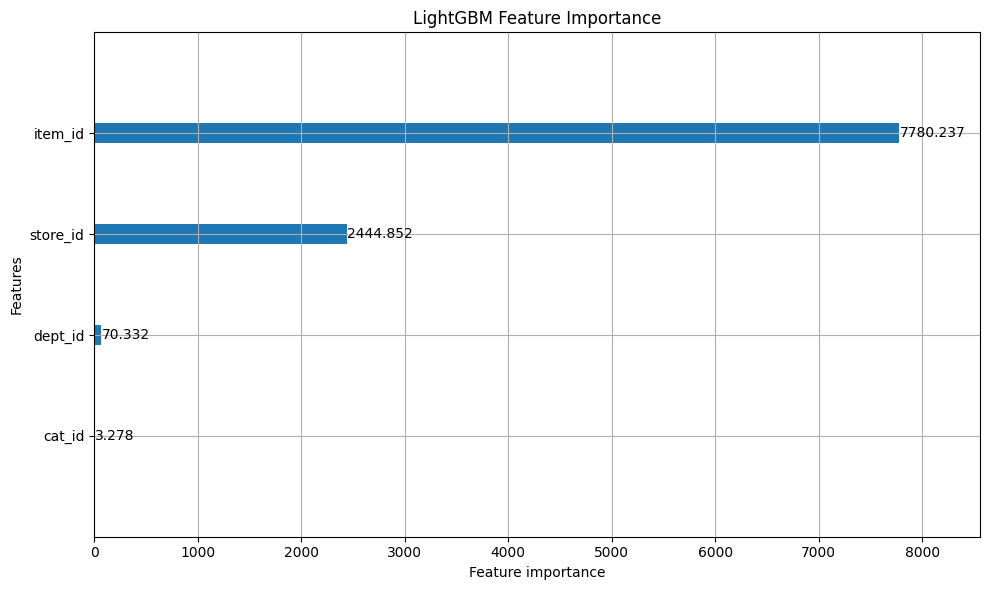

In [ ]:
def train_and_save_models(data, LIST_STEPS, data_size='improved'):
    for step in LIST_STEPS:
        print('**Training LightGBM Model for STEP: {}**'.format(step))

        FOLDER_MODEL = '/content/drive/MyDrive/models/{}/{}_Features_Improved/'.format(data_size, step)
        Path(FOLDER_MODEL).mkdir(parents=True, exist_ok=True)

        # Define features for this step based on your logic
        COLS_SCOPE = define_features_for_step(step, data.columns)  # Pass data.columns directly

        if not COLS_SCOPE:
            print(f"Warning: No features found for step {step}. Please define COLS_SCOPE for this step.")
            continue

        # Train model
        model = train_lightgbm(data, COLS_SCOPE)

        # Save model
        filename = FOLDER_MODEL + 'model_features_total.pkl'
        joblib.dump(model, filename)

def train_lightgbm(data, features):
    params = {
        'objective': 'poisson',
        'metric': 'rmse',
        'force_row_wise': True,
        'learning_rate': 0.1,  # Adjust learning rate
        'sub_row': 0.75,
        'bagging_freq': 1,
        'lambda_l2': 0.1,
        'verbosity': 1,
        'num_iterations': 1000,  # Adjust number of iterations
        'num_leaves': 128,  # Adjust tree depth
        'min_data_in_leaf': 100,
    }

    train_data = lightgbm.Dataset(data[features], label=data['sold'])

    model = lightgbm.train(params, train_data, valid_sets=[train_data])

    return model

    # Implementation of LightGBM training

def analyze_feature_importance(data, LIST_STEPS, data_size='improved'):
    for step in LIST_STEPS:
        print('**Features Importance for STEP: {}**'.format(step))

        FOLDER_MODEL = '/content/drive/MyDrive/models/{}/{}_Features_Improved/'.format(data_size, step)
        Path(FOLDER_MODEL).mkdir(parents=True, exist_ok=True)

        # Load the model
        filename = FOLDER_MODEL + 'model_features_total.pkl'
        model = joblib.load(filename)

        # Define features for the current step
        features = define_features_for_step(step, data.columns)

        # Plot feature importance
        fig, ax = plt.subplots(figsize=(10, 6))
        lightgbm.plot_importance(model, ax=ax, importance_type='gain', title='LightGBM Feature Importance')
        plt.tight_layout()

        # Save the plot
        fig.savefig(FOLDER_MODEL + 'Features_Importance_{}.png'.format(step))
        plt.show()

def define_features_for_step(step, all_columns):
    if step == 1:
        # Use columns related to item information
        return ['item_id', 'dept_id', 'cat_id', 'store_id']

    elif step == 2:
        # Use columns related to price information
        return ['sell_price', 'delta_price_all_rel', 'delta_price_cat_rel']

    elif step == 3:
        # Use columns related to lagged sales
        return [col for col in all_columns if 'sold_lag_' in col]

    elif step == 4:
        # Use columns related to averages and rolling max
        return ['iteam_sold_avg', 'state_sold_avg', 'store_sold_avg', 'cat_sold_avg', 'dept_sold_avg', 'rolling_sold_max']

    else:
        return []

def analyze_features_importance(data, folder_model):
    feature_importance_df = pd.DataFrame()

    filename = folder_model + 'model_features_total.pkl'
    # load model
    model = joblib.load(filename)

    # Create features importance for this model
    feature_importance_df["feature"] = data.columns
    feature_importance_df["importance"] = model.feature_importances_

    return feature_importance_df


def main():
    data_size = 'improved'

    data = preprocess_data(data_size)

    # Cell 20: Import Data and Reduce to 50%
    data = data.sample(frac=0.0001, random_state=42).reset_index(drop=True)
    start_row = 55
    data = data[data['d'] >= start_row].copy()

    # Write the reduced DataFrame to Parquet format
    #data.to_parquet('reduced_data.parquet', index=False)

    LIST_STEPS = [1, 2, 3, 4]
    train_and_save_models(data, LIST_STEPS)

    analyze_feature_importance(data, LIST_STEPS, data_size)

if __name__ == "__main__":
    main()

In [ ]:
!pip install --upgrade typing-extensions


  Using cached typing_extensions-4.8.0-py3-none-any.whl.metadata (3.0 kB)
Using cached typing_extensions-4.8.0-py3-none-any.whl (31 kB)
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.5.0
    Uninstalling typing_extensions-4.5.0:
      Successfully uninstalled typing_extensions-4.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-probability 0.22.0 requires typing-extensions<4.6.0, but you have typing-extensions 4.8.0 which is incompatible.


In [ ]:
!pip install gradio



In [ ]:
import gradio as gr
import pandas as pd
import numpy as np
import lightgbm
import joblib

In [ ]:
data_size='improved'
step=1
FOLDER_MODEL = '/content/drive/MyDrive/models/{}/{}_Features_Improved/'.format(data_size, step)
filename = FOLDER_MODEL + 'model_features_total.pkl'
model = joblib.load(filename)
data = preprocess_data(data_size)
# Get the feature names from the DataFrame columns
features_to_use = data.columns.tolist()

def predict_sales(data, *args):
    # Convert input values to a DataFrame with appropriate column names
    input_data = pd.DataFrame([args], columns=features_to_use)

    # Make predictions using the trained model
    prediction = model.predict(input_data)

    return prediction[0]

# Gradio UI
iface = gr.Interface(
    fn=predict_sales,
    inputs=[gr.Textbox(label=feature, type='text') for feature in features_to_use],
    outputs=gr.Textbox(label='Predicted Sales', type='text')
)

# Launch the Gradio interface
iface.launch()

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://5c5bf21ce353873f80.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
